<a href="https://colab.research.google.com/github/PoilenkovaAnna/BCI_EEG_EMG/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BC%D1%8B%D1%81%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE_%D0%BF%D1%80%D0%BE%D0%B8%D0%B7%D0%BD%D0%BE%D1%81%D0%B8%D0%BC%D1%8B%D1%85_%D1%84%D0%BE%D0%BD%D0%B5%D0%BC_EEG%2BEMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install mne

In [ ]:
import os
import json
import subprocess
import traceback

import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import statistics

import mne
import scipy
import json

import pandas as pd
import numpy as np
import random
import cv2

from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from os import walk
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
import torchvision

In [ ]:
# Задача распознования по ЭЭГ
EEG_SETS = [
        ['EEG F7-A1', 'EEG F7-M1'],
        ['EEG F3-A1', 'EEG F3-M1'],
        ['EEG T3-A1', 'EEG T3-M1'],
        ['EEG C3-A1', 'EEG C3-M1'],
]

# Задача распознования по ЭЭГ + ЭМГ
EEG_and_EMG_SETS = [
        ['EEG F7-A1', 'EEG F7-M1'],
        ['EEG F3-A1', 'EEG F3-M1'],
        ['EEG T3-A1', 'EEG T3-M1'],
        ['EEG C3-A1', 'EEG C3-M1'],
        ['EEG Oz-A2','EEG Oz-M2'],
        ['EEG Fpz-A2','EEG Fpz-M2']
]

# используемые каналы
TARGET_CHANNEL_SETS = EEG_and_EMG_SETS

# кол-во каналов для подачи в модель
TARGET_CHANNELS = 4

'''
1. Задача классификации ЭЭГ
TARGET_CHANNEL_SETS = TARGET_CHANNELS = 4


2. Задача классификации ЭЭГ с использованием временной метки начала мысленного проговаривания по данным ЭМГ
TARGET_CHANNEL_SETS = 6
TARGET_CHANNELS = 4 

3. Задача классификации ЭЭГ и ЭМГ
TARGET_CHANNEL_SETS = TARGET_CHANNELS = 6

'''


# Параметры для вейвлет-преобразования
SOURCE_FREQ         = 1000  # Article: 1000Hz
SECTOR_LENGTH       = 500
SECTOR_LENGTH_STEPS = 500
MAX_MORLET_FREQ     = 30
MORLET_FREQ_STEPS   = 30
LOW_PASS_FREQ       = 3
HIGH_PASS_FREQ      = 30
MAX_SAMPLE_LENGTH   = 1.5

# Phonemes are enumerated in range 1, 2, 3, 4, 5, 6, 7
MIN_PHONEME_ID = 1 # для смещения фонем к 0
PHONEME_COUNT  = 7 # Бинарная - 1, Многоклассовая - 7

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__  = dict.get
    __setattr__  = dict.__setitem__
    __delattr__  = dict.__delitem__

    def copy(self):
        my_copy = type(self)()
        for k, v in self.items():
            my_copy[k] = v
        return my_copy

In [ ]:
# настройки для модели
test_config = dotdict()


# Train properties
test_config.test_size         = 0.2
test_config.batch_size        = 8
test_config.epochs            = 50
test_config.use_conv_sigmoid  = False
test_config.use_dense_sigmoid = False # test_config.binary

# Train autoconfig
test_config.lr_step_size     = 40
test_config.lr_start         = 0.01

# Transform properties
test_config.shift_transform_scale = 1.1
test_config.shift_transform_roll  = 1.0
test_config.noise_transform_scale = 0.00001
test_config.make_flip_along_time  = False

test_config.seed       = 42
test_config.seed_steps = 1


test_config.conv_layers = [
    {
        'out': 8,
        'kernel': (1, 4),
        'pool': (2, 2),
        'dropout': 0.001
    },
    {
        'out': 16,
        'kernel': (3, 5),
        'pool': (2, 2),
        'dropout': 0.001
    },
    {
        'out': 32,
        'kernel': (1, 4),
        'pool': (2, 2),
        'dropout': 0.001
    }
]

test_config.dense_layers = (
    {
        'count': 128,
        'dropout': 0
    },
)

## Открываем данные

In [ ]:
myography_prosebaya_path = '/content/drive/MyDrive/Colab Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya'
myography_vsluh_path = '/content/drive/MyDrive/Colab Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_vsluh'

myography_prosebaya_filenames = sorted(next(walk(myography_prosebaya_path), (None, None, []))[2])
myography_vsluh_filenames = sorted(next(walk(myography_vsluh_path), (None, None, []))[2])

edf_prosebaya = []
for filename in myography_prosebaya_filenames:
    file_with_path = f'{myography_prosebaya_path}/{filename}'
    edf = mne.io.read_raw_edf(file_with_path)
    edf_prosebaya.append(edf)

edf_vsluh = []    
for filename in myography_vsluh_filenames:
    file_with_path = f'{myography_vsluh_path}/{filename}'
    edf = mne.io.read_raw_edf(file_with_path)
    edf_vsluh.append(edf)

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/AbrosimovaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/AlyaksinaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/MorozovaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/NoginaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab Not

## Выделение каналов, сегментация

In [ ]:
def extract_strict_sectors(edf, sector_length = 900 ): 
	"""
	Extract sectors of the given length using labels.
	Sample usage is extracting sectors of length 600 ms (1000Hz).

	Returns segments[begin,end] and labels

		** 1n восприятие / n проговаривание
	"""
	sectors = []
	labels = []

	number_of_current_phoneme = None
	counter = 0
	silent_speach = False
	
	METKA = edf['METKA']
	X = METKA[1]
	Y = METKA[0].T[:,0]
  
	for index, (timestamp, value) in enumerate(zip(X, Y)):
		counter-=1 
		if value > 0:
			value = int(value)
			
			# segment begin of silent speach 
			if value // 10 == 0:  
				counter = sector_length + 100
				number_of_current_phoneme = value % 10
				silent_speach = True
			else:
				silent_speach = False # another label 
        
		if silent_speach and counter == 0: 
			sectors.append((index - sector_length, index))
			labels.append(number_of_current_phoneme)
	
	return sectors, labels

In [ ]:
def subselect_channels(edf, target_channels = TARGET_CHANNEL_SETS ):
    all_channels = edf.ch_names
    channels = []

    for target_channel in target_channels:
        for channel_name_optiont in target_channel:
            if channel_name_optiont in all_channels:
                data_channel = edf[channel_name_optiont]
                Y_channel = list(data_channel[0][0]) # Значения сигнала
                X_channel = data_channel[1] # Время 
                channels.append(Y_channel)
    
    if len(channels) != len(target_channels):
         raise RuntimeError(f'Not all channels found')
    else:
        return channels

In [ ]:
def split_sectors(channels_data, sectors):
    '''
    Выделяем сегменты из данных по каналам, используя сектора
    '''
    splitted  = [[None] * len(sectors) for i in range(len(channels_data))]
    
    for i_sector, sector in enumerate(sectors):
        a, b  = sector

        for i_channel, channel_data in enumerate(channels_data):
            splitted[i_channel][i_sector] = channel_data[a:b]
            
    return splitted


In [ ]:
def get_person_segments(efd, target_channels = TARGET_CHANNEL_SETS):
    '''
    Получаем из данных efd испытуемого сегменты с метками по целевым каналам (target_channels)
    '''
    channels_data = subselect_channels(efd, target_channels)
    sectors, labels = extract_strict_sectors(efd)

    segments = [[None] * len(sectors) for i in range(len(channels_data))]
    
    for i_sector, sector in enumerate(sectors):
        a, b  = sector

        for i_channel, channel_data in enumerate(channels_data):
            segments[i_channel][i_sector] = channel_data[a:b]
            
    return segments, labels


In [ ]:
def normalize_labels(labels, min_phoneme_id = MIN_PHONEME_ID):
    return [p - min_phoneme_id for p in labels]

In [ ]:
efd_person = edf_prosebaya[0]

In [ ]:
segments, labels = get_person_segments(efd_person, target_channels = TARGET_CHANNEL_SETS )
labels = normalize_labels(labels)

In [ ]:
print("Кол-во каналов - ", len(segments))
print("Кол-во сегментов в канале - ", len(segments[0]))

Кол-во каналов -  6
Кол-во сегментов в канале -  173


In [ ]:
# для бинарной классификации
def get_two_segments_by_labels(segments, labels, label0 = 1, label1 = 2):
    segments_by_label0 = [[] for i in range(len(segments))]
    segments_by_label1 = [[] for i in range(len(segments))]
    
    for i_channel, channel in enumerate(segments):
        for i_segment, (segment, l) in enumerate(zip(channel, labels)):
            if l == label0:
                segments_by_label0[i_channel].append(segments[i_channel][i_segment])
                
            if l == label1:
                segments_by_label1[i_channel].append(segments[i_channel][i_segment])
                            
    return (segments_by_label0, [0]*len(segments_by_label0[0])), (segments_by_label1, [1]*len(segments_by_label1[0]))    

## Определение начала мысленного проговаривания по данным ЭМГ 

In [ ]:
def norm_segment(segment):
    return segment - np.mean(segment)

In [ ]:
def get_short_time_energy(timeserie, size_frame = 100):
    timeserie = [*([0]*size_frame), *timeserie]# дополняем нулями 
    return [sum((np.array(timeserie[i_start_frame:i_start_frame + size_frame])**2)/2*size_frame) for i_start_frame  in range(len(timeserie)-size_frame)]

In [ ]:
def search_beginning(short_time_energy, limit_of_speech_absence = 100, r = 0.15, k = 4, m = 2.5 ):
    segment_without_speech = short_time_energy[:limit_of_speech_absence] 
    segment_with_speech = short_time_energy[limit_of_speech_absence:] 
    
    IMX = max(segment_with_speech)
    IMN = np.mean(segment_without_speech)
    
    # уровень, который составляет 3 процента от пиковой энергии (с поправкой на энергию тишины )
    I1 = r*(IMX - IMN) + IMN # исправила на 10%

    I2 = k*IMN
    
    # нижний порог
    ITL = min(I1, I2)
    
    # верхний порог
    ITU = m*ITL

    i_u = [time + limit_of_speech_absence for time, speech in enumerate(segment_with_speech)if speech >= ITU ]
    i_l = [time + limit_of_speech_absence for time, speech in enumerate(segment_with_speech) if speech <= ITL ]
    
    if len(i_l) == 0 or len(i_u) == 0:
        return limit_of_speech_absence 
    
    I1 = [time for time in i_l if time <= i_u[0] ]

    if len(I1) == 0:
        return limit_of_speech_absence 

    N = I1[len(I1)-1]
    if N > 350:
        return 350
    if N < 100:
        return 350

    return I1[len(I1)-1]

In [ ]:
def get_new_intervals(segments, sector_length = SECTOR_LENGTH):
    # каналы ЭМГ
    new_intervals = []
    for (emg0, emg1) in zip(segments[4], segments[5]):

        short_time_energy0 = get_short_time_energy(norm_segment(emg0))
        short_time_energy1 = get_short_time_energy(norm_segment(emg1))

        N0 = search_beginning(short_time_energy0)
        N1 = search_beginning(short_time_energy1)

        # временая метока начала мысленного проговаривания
        N = min(N0, N1)
        new_intervals.append((N, N+sector_length))
    return new_intervals

In [ ]:
def make_segments_centered(segments, sector_length = SECTOR_LENGTH):
    new_intervals = get_new_intervals(segments)

    for i_channel, channel in enumerate(segments):
        for i_segment, (segment,  new_interval) in  enumerate(zip(channel, new_intervals)):
            a, b =  new_interval
            segments[i_channel][i_segment] = segment[a:b]
    return segments

In [ ]:
new_segments = make_segments_centered(segments)

## Функции вейвлет - преобразования 

In [ ]:
def butterworth_filter_pass(edf, channels_data):
    filtered = [None] * TARGET_CHANNELS

    for index, cd in enumerate(channels_data):
        filtered[index] = mne.filter.filter_data(cd, SOURCE_FREQ, LOW_PASS_FREQ, HIGH_PASS_FREQ, method='iir')

    return filtered


def single_morlet_wavelet_pass(sample, w = 6.0):
    """
    Apply wavelet transform on the givven sample
    """

    t, dt = np.linspace(0, SECTOR_LENGTH / SOURCE_FREQ, SECTOR_LENGTH, retstep=True)
    freq = np.linspace(1, MAX_MORLET_FREQ, MAX_MORLET_FREQ)
    fs = 1 / dt
    widths = w * fs / (2 * freq * np.pi)

    return t[::SECTOR_LENGTH // SECTOR_LENGTH_STEPS], freq[::MAX_MORLET_FREQ // MORLET_FREQ_STEPS], scipy.signal.cwt(sample, scipy.signal.morlet2, widths, w=w)[::MAX_MORLET_FREQ // MORLET_FREQ_STEPS, ::SECTOR_LENGTH // SECTOR_LENGTH_STEPS]


def rescale_morlet_plz(sample):
    """
    Rescale from shape (MAX_MORLET_FREQ, SECTOR_LENGTH) to shape
    (MORLET_FREQ_STEPS, SECTOR_LENGTH_STEPS)
    """

    NW = SECTOR_LENGTH_STEPS
    FW = (SECTOR_LENGTH // SECTOR_LENGTH_STEPS)

    if SECTOR_LENGTH == SECTOR_LENGTH_STEPS:
        return sample

    sample = np.reshape(sample, (MAX_MORLET_FREQ, NW, FW)).mean(axis=2)

    if MAX_MORLET_FREQ != MORLET_FREQ_STEPS:
        raise RuntimeError('Incomplete code')

    return sample


def morlet_wavelet_pass(channel_splitted_data, w = 6.0):
    """
    Performs wavelet transform over the given data. Returns 2D matrixes
    representing morlet transform application result for each of 4 channels for
    each of N samples.

    channel_splitted_data contains 4 channels, each has a set of splitted
    samples in it.
    """

    t, dt = np.linspace(0, SECTOR_LENGTH / SOURCE_FREQ, SECTOR_LENGTH, retstep=True)
    freq = np.linspace(1, MAX_MORLET_FREQ, MAX_MORLET_FREQ)
    fs = 1 / dt
    widths = w * fs / (2 * freq * np.pi)

    FW = (MAX_MORLET_FREQ // MORLET_FREQ_STEPS)
    FH = (SECTOR_LENGTH // SECTOR_LENGTH_STEPS)

    return t[::FH], freq[::FW], [
        [
            rescale_morlet_plz(scipy.signal.cwt(channel_splitted_data[channel][index], scipy.signal.morlet2, widths, w=w))
            for index in range(len(channel_splitted_data[channel]))
        ]
        for channel in range(TARGET_CHANNELS)
    ]

def transpose_morlet_channel_data(morlet_channel_data):
    """
    Perform transposition of channel data so order changes from

    morlet_channel_data[channel][index]

    to

    morlet_channel_data[index][channel]
    """

    return [
        [
            morlet_channel_data[channel][index]
            for channel in range(TARGET_CHANNELS)
        ]
        for index in range(len(morlet_channel_data[0]))
    ]


def abs_morlet_data(morlet):
    return np.abs(morlet)

## Преобразование сегментов в спектограммы

In [ ]:
def convert_person_segments_to_spectrograms(segments):

    t, freq, morlets = morlet_wavelet_pass(segments)

    person_spectrograms = transpose_morlet_channel_data(morlets)
    person_spectrograms = abs_morlet_data(person_spectrograms )

    return person_spectrograms

In [ ]:
def normalize_spectrograms(spectrograms):
    return spectrograms / (spectrograms.max() - spectrograms.min())

In [ ]:
def group_spectrograms_by_phoneme(labels, spectrograms):
    spectrograms_by_phoneme = [[] for _ in range(len(set(labels)))]

    for i, (spectrogram, label) in enumerate(zip(spectrograms, labels)):
        spectrograms_by_phoneme[label].append((spectrogram))
   
    return spectrograms_by_phoneme

In [ ]:
person_spectrograms = convert_person_segments_to_spectrograms(segments)
person_spectrograms = normalize_spectrograms(person_spectrograms)
print('До обьединения по фонемам ', person_spectrograms.shape)

До обьединения по фонемам  (173, 4, 30, 500)


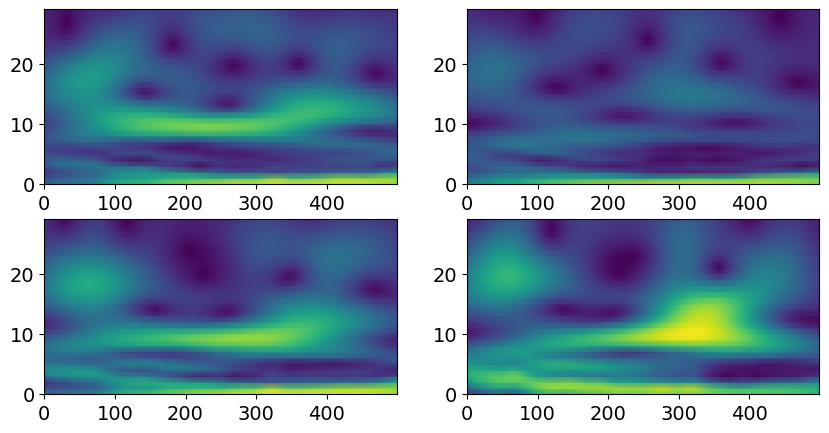

In [ ]:
# выведем первую спектограмму

index = 11

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 14
fig, axs = plt.subplots(2, 2)

for channel in range(4):
    value = np.abs(person_spectrograms[index][channel])
    
    axs[channel % 2][channel // 2].pcolormesh( value, cmap='viridis', shading='gouraud')

plt.show()

## Подготовка Dataset


In [ ]:
def train_test_split(labels, morlets, test_size):
    indices = np.arange(len(morlets))
    np.random.shuffle(indices)

    labels = np.array(labels)[indices]
    morlets =  morlets[indices]
    train_count = int(len(morlets) * (1.0 - test_size))

    train_labels, train_morlets = labels[0:train_count], morlets[0:train_count]
    test_labels, test_morlets = labels[train_count:-1], morlets[train_count:-1]
    return train_labels, train_morlets, test_labels, test_morlets

In [ ]:
class NoiseTransform(object):
    
    def __init__(self, noise_scale):
        self.noise_scale = noise_scale

    def __call__(self, sample):
        morlet = sample
        return morlet + np.random.normal(0, self.noise_scale, morlet.shape)


class ToTensor(object):

    def __call__(self, sample):
        morlet = sample

        return torch.from_numpy(morlet.copy())

In [ ]:
class PSDataset(Dataset):  # Person Spectrograms Dataset
  
    def __init__(self, labels, spectrograms, transform=None, target_transform=None):
        self.labels = labels
        self.spectrograms = spectrograms
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        spectrogram, label = self.spectrograms[idx], self.labels[idx]
        if self.transform:
            spectrogram = self.transform(spectrogram)
        if self.target_transform:
            label = self.target_transform(label)
        return spectrogram, label


In [ ]:
train_labels, train_morlets, test_labels, test_morlets = train_test_split(labels, person_spectrograms, test_config.test_size)

train_transform = torchvision.transforms.Compose([
    NoiseTransform(test_config.noise_transform_scale), 
    ToTensor(),
])

test_transform = torchvision.transforms.Compose([
    ToTensor()
])

print(f'Размер входных данных - {len(train_morlets[0])}, { len(train_morlets[0][0])},  { len(train_morlets[0][0][0])}')
train_data = PSDataset(train_labels, train_morlets, train_transform)
test_data = PSDataset(test_labels, test_morlets, test_transform)

train_loader = DataLoader(train_data, batch_size = test_config.batch_size, shuffle=True)
test_loader = DataLoader(test_data, shuffle=False) 

Размер входных данных - 4, 30,  500


## Настройка модели


### Model


In [ ]:
class MNetwork(torch.nn.Module):

    def __init__(self, conv_layers, dense_layers, num_classes, use_conv_sigmoid=False, use_dense_sigmoid=False, print_log=False):
        super().__init__()

        self.conv = []
        self.pool = []
        self.conv_dropout = []
        self.fc = []
        self.fc_dropout = []

        self.use_conv_sigmoid = use_conv_sigmoid
        self.use_dense_sigmoid = use_dense_sigmoid

        self.conv_layers = conv_layers
        self.dense_layers = dense_layers
        self.num_classes = num_classes


        last_conv_out = TARGET_CHANNELS
        result_dimension = [TARGET_CHANNELS, MORLET_FREQ_STEPS, SECTOR_LENGTH_STEPS]
        for i, layer in enumerate(conv_layers):
            self.conv.append(torch.nn.Conv2d(last_conv_out, layer['out'], layer['kernel']))
            self.__setattr__(f'conv{i}', self.conv[-1])
            last_conv_out = layer['out']

            self.pool.append(torch.nn.MaxPool2d(layer['pool']))
            self.__setattr__(f'pool{i}', self.pool[-1])

            self.conv_dropout.append(torch.nn.Dropout(layer['dropout']))
            self.__setattr__(f'conv_dropout{i}', self.conv_dropout[-1])

            # Recalculate dimensions
            result_dimension[0] = layer['out']
            result_dimension[1] = result_dimension[1] - layer['kernel'][0] + 1
            result_dimension[2] = result_dimension[2] - layer['kernel'][1] + 1
            result_dimension[1] = result_dimension[1] // layer['pool'][0]
            result_dimension[2] = result_dimension[2] // layer['pool'][1]

        if print_log:
            print('conv-dense dimension:', result_dimension)

        # Add fully connected
        # dense_layers contain only layers sizes between input and output of dense net
        # Input of the dense has dimensions of the last conv layer
        # Outputs of the dense has dimensions of the num_classes
        last_fc_out = result_dimension[0] * result_dimension[1] * result_dimension[2]
        for i, layer in enumerate(dense_layers):
            self.fc.append(torch.nn.Linear(last_fc_out, layer['count']))
            self.__setattr__(f'fc{i}', self.fc[-1])
            last_fc_out = layer['count']

            self.fc_dropout.append(torch.nn.Dropout(layer['dropout']))
            self.__setattr__(f'fc_dropout{i}', self.fc_dropout[-1])

        # Append last fc layer
        self.fc.append(torch.nn.Linear(last_fc_out, num_classes))

    def forward(self, x):
        # Apply conv
        for conv, pool, drop in zip(self.conv, self.pool, self.conv_dropout):
            if self.use_conv_sigmoid:
                x = drop(pool(torch.sigmoid(conv(x))))
            else:
                x = drop(pool(torch.relu(conv(x))))

        # Flatten
        x = torch.flatten(x, 1)

        # Dense
        for fc, drop in zip(self.fc[:-1], self.fc_dropout):
            if self.use_dense_sigmoid:
                x = drop(torch.sigmoid(fc(x)))
            else:
                x = drop(torch.relu(fc(x)))

        x = self.fc[-1](x)

        return x

    def save_model(self, filename):
        config = {
            'conv_layers': self.conv_layers,
            'dense_layers': self.dense_layers,
            'num_classes': self.num_classes,
            'use_conv_sigmoid': self.use_conv_sigmoid,
            'use_dense_sigmoid': self.use_dense_sigmoid
        }

        # Save config
        with open(f'{filename}-config.json', 'w') as f:
            json.dump(config, f)

        # Save all parameters
        for i, conv in enumerate(self.conv):
            state = conv.state_dict()

            for key in state.keys():
                torch.save(state[key], f'{filename}-conv{i}-{key}.tensor')

        # Save all parameters
        for i, fc in enumerate(self.fc):
            state = fc.state_dict()

            for key in state.keys():
                torch.save(state[key], f'{filename}-fc{i}-{key}.tensor')


def load_model(filename):
    # Save config
    with open(f'{filename}-config.json', 'r') as f:
        config = json.load(f)

    # Create model
    model = MNetwork(config['conv_layers'], config['dense_layers'], config['num_classes'], config['use_conv_sigmoid'], config['use_dense_sigmoid'])

    # Save all parameters
    for i, conv in enumerate(model.conv):
        state = conv.state_dict()

        for key in state.keys():
            state[key] = torch.load(f'{filename}-conv{i}-{key}.tensor')

        conv.load_state_dict(state)

    # Save all parameters
    for i, fc in enumerate(model.fc):
        state = fc.state_dict()

        for key in state.keys():
            state[key] = torch.load(f'{filename}-fc{i}-{key}.tensor')

        fc.load_state_dict(state)

    return model

 ### Функции для обучения

In [ ]:
def train_model(model: MNetwork, train_loader, optimizer, criterion, epochs, scheduler = None ):
   
    for epoch in range(epochs):
        model.train()
        for iter,  batch in enumerate(train_loader):

            morlets, labels =  batch

            logits = model(morlets.float()) 
            
            if logits.shape[-1] == 1: # бинарная 
                logits = torch.sigmoid(logits.flatten())
                loss = criterion(logits, labels.float())
            else:
                loss = criterion(logits, labels) # Многоклассовая

            if iter % 400 == 0:
                print(loss.item(),  file = f )
                print(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

In [ ]:
def calculate_match_on_dataset(model: MNetwork, test_dataset):
    count = 0

    with torch.no_grad():
        model.eval()
        for morlet, label in test_dataset:
            output = model(morlet[...].float())
            if output.shape[-1] == 1:
                count += ((output > 0.5).int() == label).sum().item()
            else:
                predicted = torch.argmax(output, 1)
                count += (predicted == label).sum().item()
    return count / len(test_dataset)

 ## Обучение модели

### Бинарная классификация


In [ ]:
f = open("/content/drive/MyDrive/Colab Notebooks/ipp-clf-eeg/bin.txt", "a")

In [ ]:
# БИНАРНАЯ КЛАССИФИКАЦЯИ 
match_res = []
num_classes = 1
# Set seed
seed =42
np.random.seed(seed)
torch.manual_seed(seed)

print(f'_______________________________________________________________ ', file=f)
aver = 0 

for i_edf_person, edf_person in enumerate(edf_prosebaya):
    print(f'   ', file=f)
    print(f'Испытуемый - {i_edf_person}', file=f)
    aver = 0 
    
    print(f'===================NEW PERSON=====================', file=f)
    print(f'===================NEW PERSON=====================')
    
    segments, all_labels = get_person_segments(edf_person, target_channels = TARGET_CHANNEL_SETS )
    all_labels = normalize_labels(all_labels, MIN_PHONEME_ID )

    segments = make_segments_centered(segments)[0:4]
    
    for i_label0 in range(7):
        for i_label1 in range(i_label0+1, 7):
            print(f'Бинарная классифика для фонем : {i_label0} - {i_label1}', file=f)
            print(f'Бинарная классифика для фонем : {i_label0} - {i_label1}')

            tuple0, tuple1 = get_two_segments_by_labels(segments, all_labels, label0 = i_label0, label1 = i_label1)

            # Фонема 1
            segments0, labels0 = tuple0 

            # Фонема 2
            segments1, labels1 = tuple1
            
            person_spectrograms0 = normalize_spectrograms(convert_person_segments_to_spectrograms(segments0))
            person_spectrograms1 = normalize_spectrograms(convert_person_segments_to_spectrograms(segments1))

            person_spectrograms = np.array([ *person_spectrograms0, *person_spectrograms1 ])
            labels =  np.array([*labels0, *labels1])

            count = 128
            outs = (20 ,25, 32)
            kernels = ((1, 2),(3, 7), (1, 2))

            out1, out2, out3 = outs
            kernel1, kernel2, kernel3 = kernels

            test_config.conv_layers = [
            {
                'out': out1,
                'kernel': kernel1,
                'pool': (2, 2),
                'dropout': 0.001
            },
            {
                'out': out2,
                'kernel': kernel2,
                'pool': (2, 2),
                'dropout': 0.001
            },
            {
                'out': out3,
                'kernel': kernel3,
                'pool': (2, 2),
                'dropout': 0.001
            }
            ]

            test_config.dense_layers = (
                {
                    'count': count,
                    'dropout': 0
                },
            )

            print(f'-------------------------------', file=f )
                
            sum_match = 0
            

            # Split
            train_labels, train_morlets, test_labels, test_morlets = train_test_split(labels, person_spectrograms, test_config.test_size)
            print(f'Метки в test - {test_labels}', file=f)
            print(f'Метки в test - {test_labels}')

            train_transform = torchvision.transforms.Compose([
                NoiseTransform(test_config.noise_transform_scale), 
                ToTensor(),
            ])

            test_transform = torchvision.transforms.Compose([
                ToTensor()
            ])
            

            train_data = PSDataset(train_labels, train_morlets, train_transform)
            test_data = PSDataset(test_labels, test_morlets, test_transform)
            
            batch_size = 8
            train_loader = DataLoader(train_data, 
                                batch_size=batch_size, shuffle=True)

            test_loader = DataLoader(test_data, shuffle=False)
            

            lr = 0.005

            model = MNetwork(
                test_config.conv_layers,
                test_config.dense_layers,
                num_classes,
                use_conv_sigmoid=test_config.use_conv_sigmoid,
                use_dense_sigmoid=test_config.use_dense_sigmoid
            )
            print(f'  MODEL  - {model}', file=f )

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = torch.nn.BCELoss()

            train_model(model, train_loader, optimizer,  criterion, test_config.epochs)
            result_match = calculate_match_on_dataset(model, test_loader) * 100

            print(f'MATCH: {round(result_match, 2)}%  lr = {lr }', file = f)
            print(f'MATCH: {round(result_match, 2)}%  lr = {lr }')
            
            print(f'-RESULT- по 3 запускам модели (каждый раз новое разбиение и обучение)', file=f )
            print(f'Бинарная классифика для фонем : {i_label0} - {i_label1}', file=f)
            print(f'Испытуемый - {i_edf_person}', file=f)
            print(f'Всего данных - {len(person_spectrograms)}, test - {len(train_data)} train - {len(test_data)}', file=f) 
            print(f'batch_size = {batch_size}, seed = {seed} \ optimizer Adam lr = {lr}', file=f)
            print(f'Средний MATCH: {sum_match/3}', file=f )
            print(f'',  file=f )
            print(f'',  file=f )
            aver+=result_match
    print(f'aver: {aver}', file=f )
    print(f'aver: {aver}')

            
f.close()

### Многоклассовая классификация

In [ ]:
match_res = []
num_classes = 7 
seed = 42

f = open("/content/drive/MyDrive/Colab Notebooks/ipp-clf-eeg/classifier/2_500.txt", "a")
for i_edf_person, edf_person in enumerate(edf_prosebaya):
    print(f'===================NEW PERSON=====================', file=f)

    for outs in [(8 ,16, 32),  (16 ,32, 32), (20 ,25, 32)]:

        for kernels in [((1, 4),(3, 5), (1, 4)), ((1, 2),(3, 7), (1, 2)), ((1, 2),(4, 4), (1, 2)), ((1, 2), (1, 2), (5, 5))]:
            for count in [128, 252]:
                out1, out2, out3 = outs
                kernel1, kernel2, kernel3 = kernels

                test_config.conv_layers = [
                {
                    'out': out1,
                    'kernel': kernel1,
                    'pool': (2, 2),
                    'dropout': 0.001
                },
                {
                    'out': out2,
                    'kernel': kernel2,
                    'pool': (2, 2),
                    'dropout': 0.001
                },
                {
                    'out': out3,
                    'kernel': kernel3,
                    'pool': (2, 2),
                    'dropout': 0.001
                }
                ]

                test_config.dense_layers = (
                    {
                        'count': count,
                        'dropout': 0
                    },
                )

                match_res_person = []

                segments, labels = get_person_segments(edf_person, target_channels = TARGET_CHANNEL_SETS )
                labels = normalize_labels(labels, MIN_PHONEME_ID )

                segments = make_segments_centered(segments)[0:4] # ЭМГ - индикатор

                person_spectrograms = convert_person_segments_to_spectrograms(segments)
                person_spectrograms = normalize_spectrograms(person_spectrograms)
                
                # Set seed
                np.random.seed(seed)
                torch.manual_seed(seed)

                # Split
                train_labels, train_morlets, test_labels, test_morlets = train_test_split(labels, person_spectrograms, test_config.test_size)
                
                train_transform = torchvision.transforms.Compose([
                    NoiseTransform(test_config.noise_transform_scale), 
                    ToTensor(),
                ])

                test_transform = torchvision.transforms.Compose([
                    ToTensor()
                ])
                
                print(f'Размер входных данных - {len(train_morlets[0])}, { len(train_morlets[0][0])},  { len(train_morlets[0][0][0])}')
                train_data = PSDataset(train_labels, train_morlets, train_transform)
                test_data = PSDataset(test_labels, test_morlets, test_transform)
                
                for batch_size in [8, 16]:

                    train_loader = DataLoader(train_data, 
                                        batch_size=batch_size, shuffle=True)
                    test_loader = DataLoader(test_data, shuffle=False)  
                    

                    print(f'Испытуемый - {i_edf_person}', file=f)
                    print(f'Всего данных - {len(person_spectrograms)}, test - {len(train_data)} train - {len(test_data)}', file=f)
                    
                    print(f'Всего данных - {len(person_spectrograms)}, test - {len(train_data)} train - {len(test_data)}')


                    for lr in [0.0005, 0.001, 0.005]:
                        
                        model = MNetwork(
                            test_config.conv_layers,
                            test_config.dense_layers,
                            num_classes,
                            use_conv_sigmoid=test_config.use_conv_sigmoid,
                            use_dense_sigmoid=test_config.use_dense_sigmoid
                        )

                        print(f'  MODEL  - {model}', file=f )
                        print(f'  MODEL  - {model}')
                        print(f'lr = {lr}, batch_size = {batch_size}, seed = {seed}', file=f)
                        print(f'lr = {lr}, batch_size = {batch_size}, seed = {seed}', file=f)
                        
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)
                        criterion = torch.nn.CrossEntropyLoss() 

                        train_model(model, train_loader, optimizer,  criterion, test_config.epochs)
                        result_match = calculate_match_on_dataset(model, test_loader) * 100

                        match_res_person.append(result_match)

                        print(f'-RESULT-)', file=f )
                        print(f'Испытуемый - {i_edf_person}', file=f)
                        print(f'Всего данных - {len(person_spectrograms)}, test - {len(train_data)} train - {len(test_data)}', file=f) 
                        print(f'batch_size = {batch_size}, seed = {seed} \ optimizer Adam lr = {lr}', file=f)
                        print(f'MATCH: {round(result_match, 2)}% ', file = f)
                        print(f'MATCH: {round(result_match, 2)}%')
f.close()   

### Проверка моделей с высоким MATCH и низким loss

In [ ]:
match_res = []
num_classes = 7 
seed = 42

test_config.conv_layers = [
{
    'out': 8,
    'kernel': (1, 2),
    'pool': (2, 2),
    'dropout': 0.001
},
{
    'out': 16,
    'kernel': (3, 7),
    'pool': (2, 2),
    'dropout': 0.001
},
{
    'out': 32,
    'kernel': (1, 2),
    'pool': (2, 2),
    'dropout': 0.001
}
]

test_config.dense_layers = (
    {
        'count': 252,
        'dropout': 0
    },
)

ever = 0
for i_edf_person, edf_person in enumerate(edf_prosebaya):

    segments, labels = get_person_segments(edf_person, target_channels = TARGET_CHANNEL_SETS )
    labels = normalize_labels(labels, MIN_PHONEME_ID )

    segments = make_segments_centered(segments)[0:4]

    person_spectrograms = convert_person_segments_to_spectrograms(segments)
    person_spectrograms = normalize_spectrograms(person_spectrograms)
    
    # Set seed
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Split

    print(f'===================NEW PERSON=====================', file=f)
    print(f'Испытуемый - {i_edf_person}', file=f)

    sum_match = 0

    for i in range(3): 
            train_labels, train_morlets, test_labels, test_morlets = train_test_split(labels, person_spectrograms, test_config.test_size)
            
            train_transform = torchvision.transforms.Compose([
                NoiseTransform(test_config.noise_transform_scale), 
                ToTensor(),
            ])

            test_transform = torchvision.transforms.Compose([
                ToTensor()
            ])
            
            print(f'Размер входных данных - {len(train_morlets[0])}, { len(train_morlets[0][0])},  { len(train_morlets[0][0][0])}')
            train_data = PSDataset(train_labels, train_morlets, train_transform)
            test_data = PSDataset(test_labels, test_morlets, test_transform)
            

            train_loader = DataLoader(train_data, 
                                batch_size=8, shuffle=True)
            test_loader = DataLoader(test_data, shuffle=False)  
            
 
            print(f'Всего данных - {len(data)}, test - {train_size} train - {test_size}', file=f)


            model = MNetwork(
                test_config.conv_layers,
                test_config.dense_layers,
                num_classes,
                use_conv_sigmoid=test_config.use_conv_sigmoid,
                use_dense_sigmoid=test_config.use_dense_sigmoid
            )
            lr = 0.005 

            print(f'  MODEL  - {model}', file=f )
            print(f'batch_size = {batch_size}, seed = {seed} \ optimizer Adam lr = {lr}\ scheduler: step_size = 70, gamma = 0.5', file=f)
            
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 70, gamma = 0.5)
            criterion = torch.nn.CrossEntropyLoss() 

            train_model(model, train_loader, optimizer, criterion, test_config.epochs, scheduler)
            result_match = calculate_match_on_dataset(model, test_loader) * 100
            print(f'MATCH: {round(result_match, 2)}% ', file = f)
            print(f'MATCH: {round(result_match, 2)}%')
            sum_match += result_match

    print(f'-RESULT-  по 3 запускам модели (каждый раз новое разбиение и обучение)', file=f )
    print(f'Испытуемый - {i_edf_person}', file=f)
    print(f'Всего данных - {len(person_spectrograms)}, test - {len(train_data)} train - {len(test_data)}', file=f) 
    print(f'batch_size = {batch_size}, seed = {seed} \ optimizer Adam lr = {lr}', file=f)
    print(f'Средний MATCH: {sum_match/3}', file=f )
    print(f'-RESULT-  по 3 запускам модели (каждый раз новое разбиение и обучение)', file=f )
    print(f'Испытуемый - {i_edf_person}')
    print(f'Всего данных - {len(person_spectrograms)}, test - {len(train_data)} train - {len(test_data)}') 
    print(f'batch_size = {batch_size}, seed = {seed} \ optimizer Adam lr = {lr}')
    print(f'Средний MATCH: {sum_match/3}')
    ever += sum_match/3
    print(f' ever { ever}')
    print(f' ever { ever}', file=f)
            
    
f.close()

Размер входных данных - 4, 30,  500
1.9372681379318237
1.949500560760498
1.9439618587493896
1.9545698165893555
1.952195644378662
1.885793924331665
1.9449478387832642
1.9501006603240967
1.7057828903198242
1.9133917093276978
1.8866910934448242
1.7505985498428345
1.6802831888198853
1.9582599401474
1.7903372049331665
1.8971701860427856
1.5147218704223633
1.9945377111434937
1.8998969793319702
1.6796116828918457
1.7014528512954712
1.8472951650619507
1.6907051801681519
1.6791017055511475
1.3417774438858032
1.6669021844863892
1.416151762008667
1.0307434797286987
1.4981111288070679
0.6941003203392029
1.1117078065872192
1.798285722732544
1.233746886253357
1.3308809995651245
0.7074374556541443
0.4865156412124634
1.0106533765792847
1.4139941930770874
0.7093678116798401
0.8365097045898438
0.5971006751060486
0.6291088461875916
0.1041184589266777
0.672507643699646
0.6149659752845764
0.6915942430496216
0.4524019956588745
0.5651763081550598
0.33272215723991394
0.12786346673965454
MATCH: 17.65%
Размер в

In [ ]:
(81.6 + 73.8 + 84.1+ 85 + 81.1+  74.2)/6

79.96666666666667